<a href="https://colab.research.google.com/github/Taehee-K/Korean-Speech-Emotion-Recognition/blob/eda/visualization/vector_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한국어 형태소 분석기
!pip install konlpy

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [53]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import *
from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Data

In [16]:
path = os.path.dirname(os.path.abspath(__file__))
os.chdir(path)

df = pd.read_csv('../data/most_common.csv')
df.head()

,speech,emotion
0,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,Angry
1,지금도 그대로 있어. 치우는 사람이 없어.,Disgust
2,맞아. 무기력증인 것 같아. 한동안 정말 바빴었거든.,Sadness
3,오늘이 발표날인데 연락이 없더라고. 그래서 알아봤더니 명단에 내 이름이 없대.,Sadness
4,그치. 개 키우는 사람이 늘어나니까 그만큼 버리는 사람도 늘어나는 거야!,Angry


# Tokenization

In [17]:
def make_corpus(text):
    komoran = Komoran()
    corpus = []
    for s in text:
        s = s.rstrip()
        # 명사, 동사, 형용사만 추출
        corpus.append([p[0] for p in komoran.pos(s) 
        if (p[0]!= '.' and p[1] in ['NNG','NNP', 'NNB', 'VV', 'VA'])])
    return corpus

In [19]:
corpus = make_corpus(df['speech'])

# Embedding

### parameter

- corpus format : [["개", "예쁘", "사놓", "끝", "키우", "사람", "많"], ["지금", "치우", "사람", "없"]]
- size : 임베딩 차원
- window : 윈도우 사이즈
- min_count : 고려할 단어의 최소 빈도 기준
- workers : cpu core 수
- iter : 반복 학습 횟수(epoch)
- sg : 0 -> CBOW, 1 -> Skip-Gram

In [21]:
# Skip-Gram embedding model
skip_gram = Word2Vec(corpus, size=100, window=3, min_count=1, workers=-1, iter=3000, sg=1)

In [ ]:
# index2word > list of words in dictionary
words = skip_gram.wv.index2word 
# word embedded vectors
vectors = skip_gram.wv.vectors
# combine words with their vectors
skip = dict(zip(words, vectors))

w2v_df = pd.DataFrame(vectors, columns = list(range(1, 101)))
w2v_df['word'] = words
w2v_df = w2v_df[['word']+list(range(1, 101))]

In [31]:
# Calculate vector for each speech

vectors = skip_gram.wv.vectors        # word vectors
empty = np.empty_like(vectors[0])     # empty array
empty[:] = np.nan                     # initialize with nan
empty                                 # empty array >> for cases where there is no speech vector

def vectors(model, speech_list):
    speech_vec = []     # list to save speech vector

    for line in speech_list:
        sp2vec = None   # speech vector
        count = 0       # count number of words
        for word in line:               # for every word in speech
            if word in model.wv.vocab:  # if in dictionary
                count += 1              # increase word count
                
                # add all word vectors
                if sp2vec is None:
                    sp2vec = model[word]   
                else:
                    sp2vec = sp2vec + model[word]

        if sp2vec is not None:
            sp2vec = sp2vec / count     # speech vector >> average of all word vectors
            speech_vec.append(sp2vec)   # add word vector to total list
        else:  # if all vectors in speech not in dictionary >> Nan
            speech_vec.append(empty)
 
    return speech_vec

In [44]:
speech_vec = vectors(skip_gram, corpus)

speech_df = pd.DataFrame(speech_vec, columns = list(range(1, 101)))
speech_df['emotion'] = df['emotion']
speech_df_dropna = speech_df.dropna()   # remove nan

# Dimensionality Reduction

* Scale Data

In [111]:
scaler = StandardScaler()
speech_scale = scaler.fit_transform(speech_df_dropna[list(range(1, 101))])

## PCA 

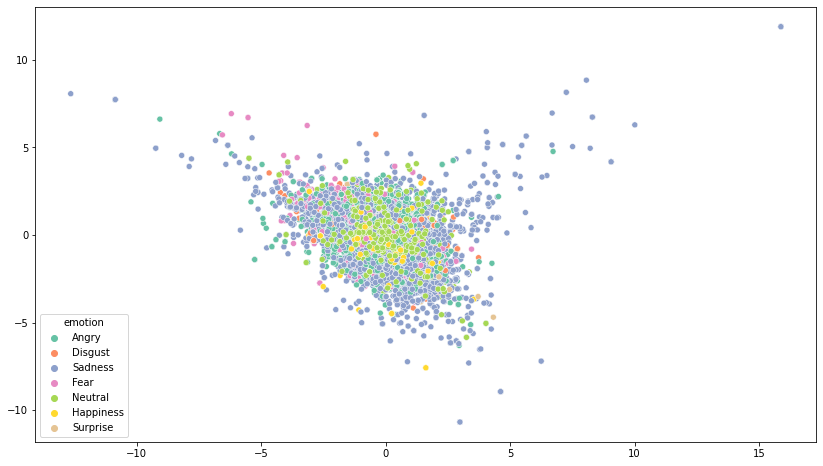

In [112]:
# 2D dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(speech_scale)

plt.figure(figsize = (14, 8))
sns.scatterplot(x = pca_res[:,0], 
                y = pca_res[:,1], 
                hue = speech_df_dropna['emotion'], 
                palette = sns.set_palette('Set2', 7), 
                legend = 'full');

## T-SNE

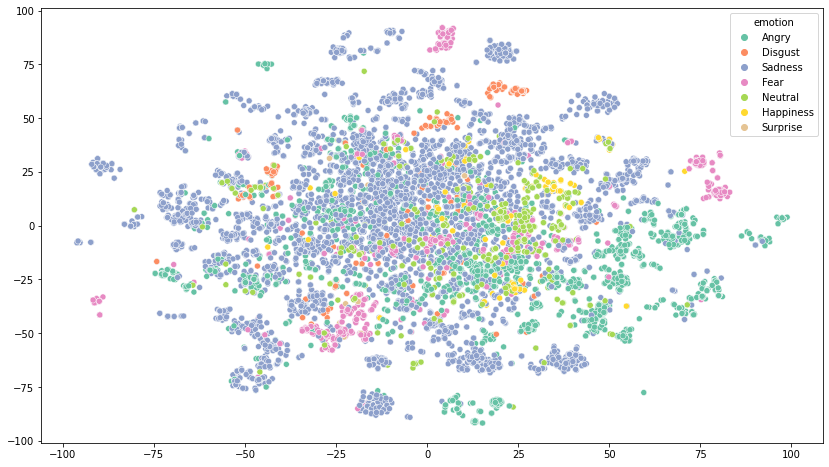

In [113]:
# 2D dimensionality reduction with T-SNE
tsne = TSNE(n_components = 2, random_state=42)
tsne_res = tsne.fit_transform(speech_scale)

plt.figure(figsize = (14, 8))
sns.scatterplot(x = tsne_res[:,0], 
                y = tsne_res[:,1], 
                hue = speech_df_dropna['emotion'], 
                palette = sns.set_palette('Set2', 7), 
                legend = 'full');